## Введение в машинное обучение

### Домашнее задание №3

Задание выполнил(а): Лунева Полина

Домашнее задание включает реализацию решающего дерева и решение задач классификации


In [218]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from typing import Iterable, List, Tuple, Union
from collections import Counter
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

# Решающее дерево своими руками (8 баллов + бонус)

В этой части для тестирования будем использовать датасет breast cancer. По предоставленной информации о ядрах клеток нужно предсказать присутствуют ли на изображении раковые клетки (класс 0) или нет (класс 1).

In [584]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(data=breast_cancer["data"], columns=breast_cancer["feature_names"])

# добавим искуственный категориальный признак
X['mean area cat'] = pd.qcut(X['mean area'], 5, labels=['smallest','small','medium','big', 'largest']).astype('object') 

X["target"] = breast_cancer["target"]
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,mean area cat,target
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915,medium,1
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,113.30,844.4,0.15740,0.3856,0.5106,0.20510,0.3585,0.11090,medium,0
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,...,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247,medium,1
446,17.75,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,...,145.40,1437.0,0.14010,0.3762,0.6399,0.19700,0.2972,0.09075,largest,0
210,20.58,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,...,158.30,1656.0,0.11780,0.2920,0.3861,0.19200,0.2909,0.05865,largest,0


### 1. Оцениванием качество разбиения (1 балл)

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

Используйте функции для подсчета значения критерия ошибки, а также для разбиения вершины из семинара:

In [3]:
def split_node(R_m: np.ndarray, feature: str, t: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Split a fixed set of objects R_m with given feature name and threshold t
    """
    mask = R_m[feature] <= t
    R_l = R_m.loc[mask]
    R_r = R_m.loc[~mask]
    return R_l, R_r


def q_error(R_m: np.ndarray, feature: str, t: float) -> float:
    """
    Compute error criterion for the given objects R_m, feature name and threshold t
    """
    R_l, R_r = split_node(R_m, feature, t)
    return  len(R_l) / len(R_m) * H(R_l['target']) + len(R_r) / len(R_m) * H(R_r['target'])

__(0.5 балла)__ Реализуйте функцию для вычисления критерия информативности. На семинаре мы рассматривали решающее дерево для регрессии и в качестве критерия качества разбиения использовали дисперсию целевой переменной. Для классификации лучше использовать другие критерии, например энтропию:

$$H(R) = -p_0\log_{2}{p_0} -p_1\log_{2}{p_1},$$ где $p_1$, $p_0$ — доля объектов среди $R$, которые относятся к классу 1 и 0 соответственно.

In [4]:
def H(y: np.ndarray) -> float:
    """
    Compute entropy for vector y with classes of objects R
        
    """
    # Проверка, чтобы не был пустой массив (может быть при разбиении), иначе будет деление на 0:
    if len(y) == 0:
        entropy = 0
    else:
        p1 = np.count_nonzero(y) / len(y)
        p0 = 1 - p1
        
        # Альтернатива:
        # p0 = np.bincount(y)[0] / len(y)
        # p1 = 1 - p0
        
        probabilities = p0, p1
        
        # Проверка, что доли объектов не равны 0, иначе будет логарифм от 0:
        if p0 == 0 or p1 == 0:
            entropy = 0
        else:
            entropy = - np.sum(probabilities * np.log2(probabilities))
            
            # Альтернатива:
            # entropy = - p0 * np.log2(p0) - p1 * np.log2(p1) 
    
    return entropy

# Проверяем на простых примерах
assert np.isclose(H([0,0,0,0,0,1]), 0.650022)
assert np.isclose(H([0,0,0,0,0,0]), 0)

__(0.5 балла)__ Выберите признак, который как вам кажется может быть полезен для предсказания и порог для него. Сравните значение критерия информативности для объектов выборки до разбиения и взвешенной суммы критериев информативности для объектов после разбиения ($Q(R_m,j,t)$). Какой можно сделать вывод?

In [125]:
# Вывод таблицы без ограничения количества столбцов:

pd.set_option('display.max_columns', None)
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,mean area cat,target
287,12.890,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,0.1532,0.4690,1.1150,12.68,0.004731,0.013450,0.016520,0.005905,0.01619,0.002081,13.620,15.54,87.40,577.0,0.09616,0.11470,0.11860,0.05366,0.2309,0.06915,medium,1
512,13.400,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,0.3906,0.9306,3.0930,33.67,0.005414,0.022650,0.034520,0.013340,0.01705,0.004005,16.410,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090,medium,0
402,12.960,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,0.2357,1.2990,2.3970,20.21,0.003629,0.037130,0.034520,0.010650,0.02632,0.003705,14.130,24.61,96.31,621.9,0.09329,0.23180,0.16040,0.06608,0.3207,0.07247,medium,1
446,17.750,28.03,117.30,981.6,0.09997,0.13140,0.16980,0.08293,0.1713,0.05916,0.3897,1.0770,2.8730,43.95,0.004714,0.020150,0.036970,0.011100,0.01237,0.002556,21.530,38.54,145.40,1437.0,0.14010,0.37620,0.63990,0.19700,0.2972,0.09075,largest,0
210,20.580,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,0.05024,0.8601,1.4800,7.0290,111.70,0.008124,0.036110,0.054890,0.027650,0.03176,0.002365,23.240,27.84,158.30,1656.0,0.11780,0.29200,0.38610,0.19200,0.2909,0.05865,largest,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,0.5262,0.8522,3.1680,25.44,0.017210,0.093680,0.056710,0.017660,0.02541,0.021930,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840,smallest,1
106,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,0.3060,1.6570,2.1550,20.62,0.008540,0.023100,0.029450,0.013980,0.01565,0.003840,13.140,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097,small,1
270,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,0.1302,0.7198,0.8439,10.77,0.003492,0.003710,0.004826,0.003608,0.01536,0.001381,14.910,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120,big,1
435,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,0.2208,0.9533,1.6020,18.85,0.005314,0.017910,0.021850,0.009567,0.01223,0.002846,17.040,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550,medium,0


In [126]:
# Описание датасета:

print(breast_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [127]:
print('Значение критерия информативности для объектов выборки до разбиения:', H(X_train['target']))

# Высокая энтропия показывает высокий уровень беспорядка (то есть нет явного преобладания класса 0 или 1)

Значение критерия информативности для объектов выборки до разбиения: 0.9513545468580795


In [128]:
# Выбран критерий 'worst radius' и порог 17:

print('Взвешенная сумма критериев информативности для объектов после разбиения:', q_error(X_train, 'worst radius', 17))

# Чем ниже критерий ошибки, тем более правильно разбиваются значения (слева и справа преобладает один класс, из-за чего низкая энтропия)

Взвешенная сумма критериев информативности для объектов после разбиения: 0.4534011467215612


In [7]:
# Вывод: разбиение можно считать достаточно удачным, так как значение критерия ошибки уменьшилось и качество распределения стало лучше

### 2. Ищем наилучшее разбиение (2 балла)

Теперь нужно найти наилучшее разбиение множества объектов $R_m$ в данной вершине, то есть такой порог $t$ для некоторого признака, где значение критерия ошибки $Q(R_m, j, t)$ минимально.

__(1 балл)__ Модифицируйте функцию *get_optimal_split* из семинара так, чтобы:
- Не было случаев, когда в одно из поддеревьев попадает 0 объектов 
- В качестве порога использовалось среднее двух различных соседних (при сортировке) значений признака 
- При одинаковых значениях критерия ошибки выбирался минимальный сплит 

__(Бонусные 0.5 балла)__ Перепешите функцию так, чтобы не использовались циклы.

In [568]:
# ЭТО НЕОБЯЗАТЕЛЬНО ПРОВЕРЯТЬ, ДАЛЕЕ ФУНКЦИЯ ДЛЯ ПРОВЕРКИ: get_optimal_split

def get_optimal_split_1(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """
    Q_array = []
    feature_values = np.sort(np.unique(R_m[feature]))
    # feature_values_sorted = np.sort(feature_values)
    
    for i in range(len(feature_values) - 1):
        # В качестве порога используется среднее двух различных соседних (при сортировке) значений признака:
        t = (feature_values[i] + feature_values[i + 1]) / 2
        
        # Альтернатива:
        # t = np.mean([feature_values[i], feature_values[i + 1]])
        
        Q_array.append(q_error(R_m, feature, t))
        
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    
    minimum_id = np.argmin(Q_array)
    opt_threshold = feature_values[minimum_id]
    opt_q_error = Q_array[minimum_id]
    
    return opt_threshold, opt_q_error, Q_array

# Первое условие выполняется, так как берутся уникальные значения в порядке возрастания (свойство встроенной функции np.unique),
# которые не могут совпадать, а значит, первый порог не будет совпадать с первым значением
# и не отсечет 0 значений в левую часть дерева.

# Третье условие выполняется, так как np.unique сортирует значения по возрастанию,
# а np.argmin берет индекс первого минимального значения (в случае наличия нескольких одинаковых).

In [569]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """
    Q_array = []
    feature_values = np.unique(R_m[feature])
    # feature_values_sorted = np.sort(feature_values)
    feature_values_1 = (feature_values[:-1] + feature_values[1:]) / 2
    
    for t in feature_values_1:
        Q_array.append(q_error(R_m, feature, t))
        
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    
    minimum_id = np.argmin(Q_array)
    opt_threshold = feature_values_1[minimum_id]
    opt_q_error = Q_array[minimum_id]
    
    return opt_threshold, opt_q_error, Q_array

# Первое условие выполняется, так как берутся уникальные значения в порядке возрастания (свойство встроенной функции np.unique),
# которые не могут совпадать, а значит, первый порог не будет совпадать с первым значением
# и не отсечет 0 значений в левую часть дерева.

# Третье условие выполняется, так как np.unique сортирует значения по возрастанию,
# а np.argmin берет индекс первого минимального значения (в случае наличия нескольких одинаковых).

In [570]:
def get_optimal_split_without_cycles(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Find best split of objects R_m by feature and return minimal q_error (opt_q_error), best threshold (opt_threshold) and array of error criterions (Q_array)
        
    """

    feature_values = np.unique(R_m[feature])
    feature_values_1 = (feature_values[:-1] + feature_values[1:]) / 2
    
    q = lambda t: q_error(R_m, feature, t)
    
    # Использование векторизации для избавления от циклов:
    q1 = np.vectorize(q)
    
    Q_array = q1(feature_values_1)
    
    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
        
    
    minimum_id = np.argmin(Q_array)
    opt_threshold = feature_values_1[minimum_id]
    opt_q_error = Q_array[minimum_id]
    
    return opt_threshold, opt_q_error, Q_array

__(0.25 балла)__ Постройте график зависимости критерия ошибки от выбранного порога для того же признака что и в 1ом задании и отметьте точку где достигается минимум.

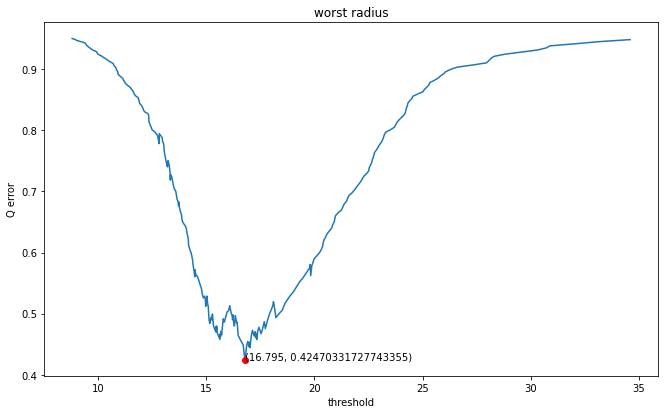

In [571]:
feature = 'worst radius'
feature_values = np.unique(X_train[feature])
feature_values_1 = (feature_values[:-1] + feature_values[1:]) / 2
t, q, Q_array = get_optimal_split_without_cycles(X_train, feature)
plt.plot(feature_values_1, Q_array)
plt.title(feature)
plt.xlabel('threshold')
plt.ylabel('Q error')

# Точка, где достигается минимум:
plt.plot(t, q, 'ro')

# Координаты этой точки:
plt.text(t, q, '({}, {})'.format(t, q))
plt.show()

__(0.75 балла)__ Найдите признак с минимальным значением критерия ошибки. Постройте на одном графике распределения значений этого признака для нулевого и первого класса (можно использовть seaborn) и добавьте прямую указывающую местоположение порога. 

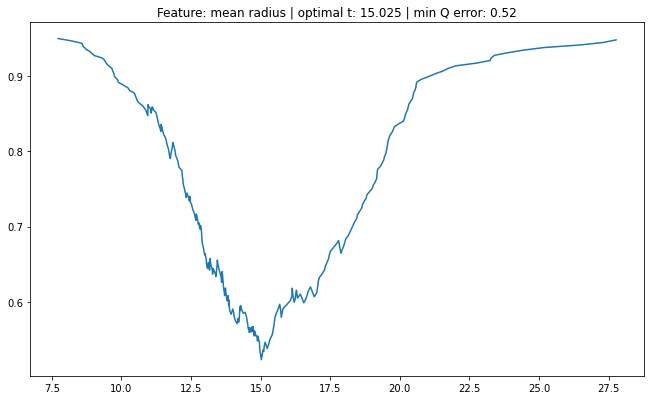

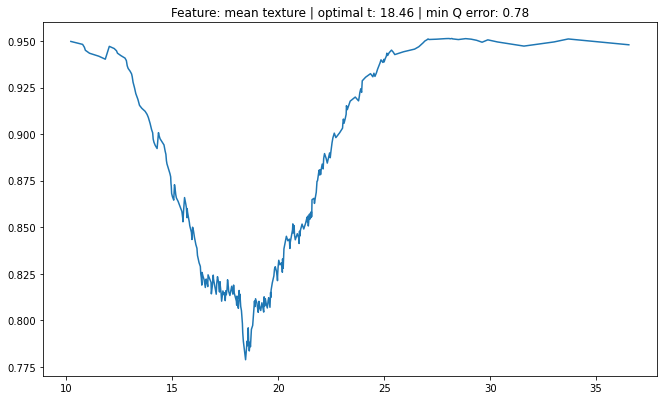

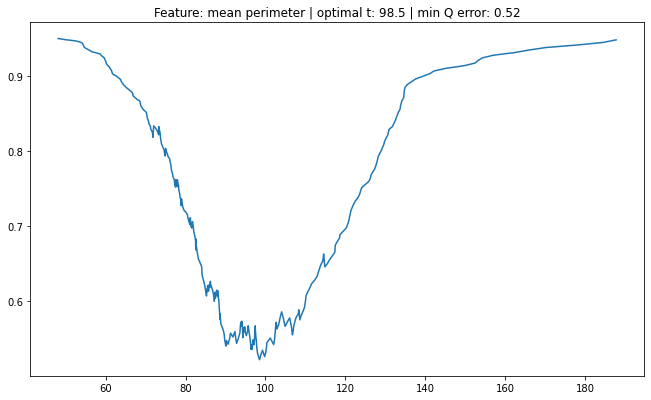

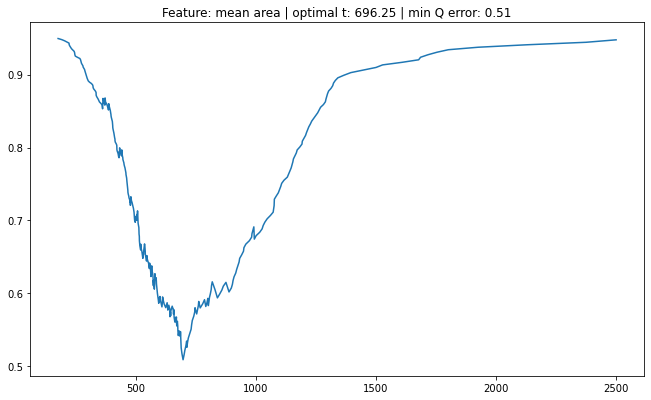

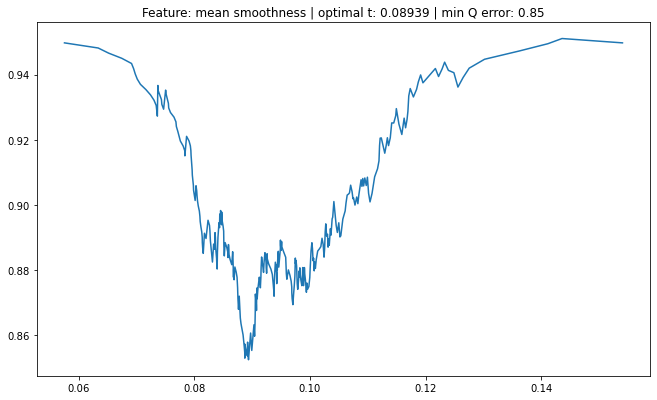

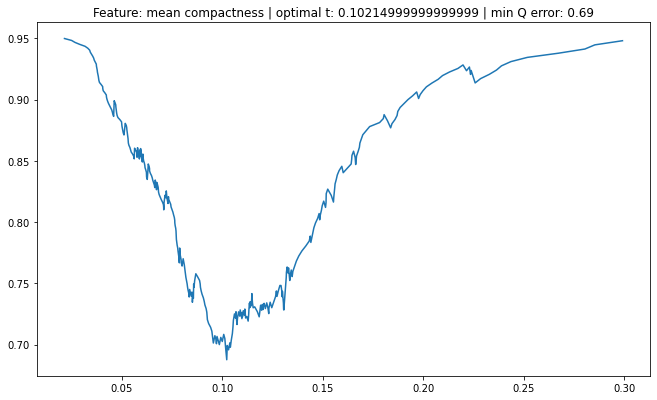

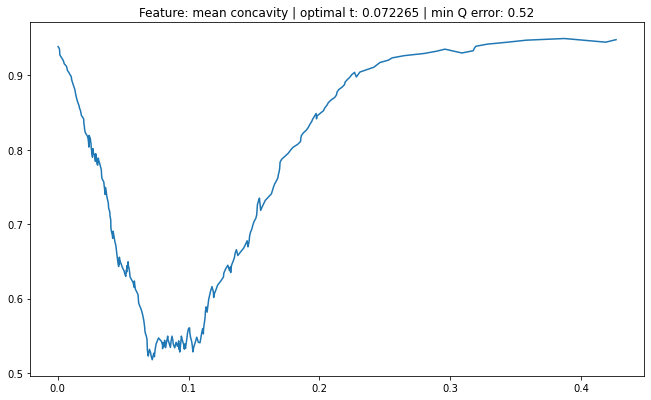

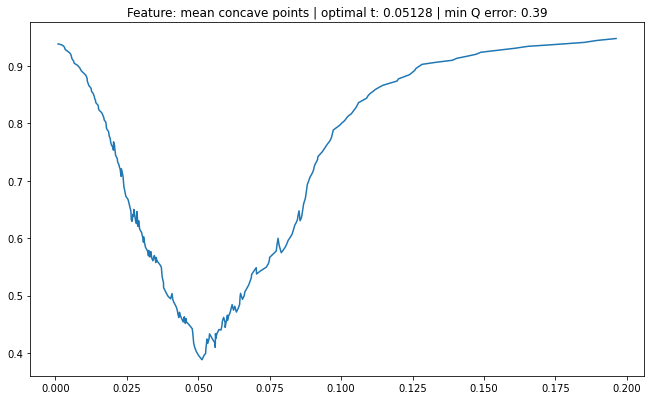

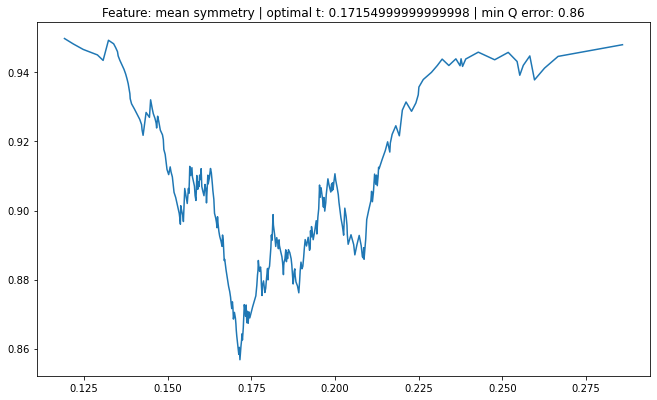

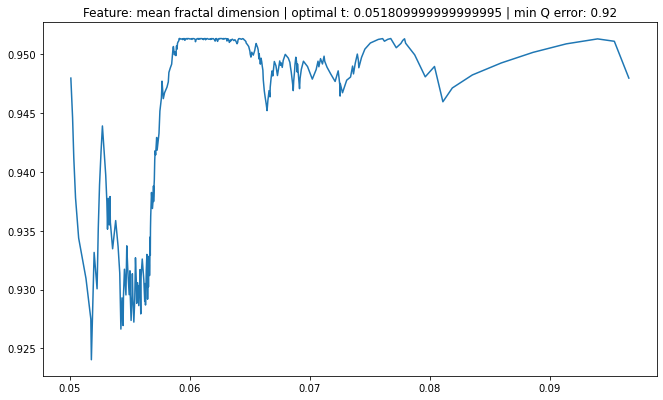

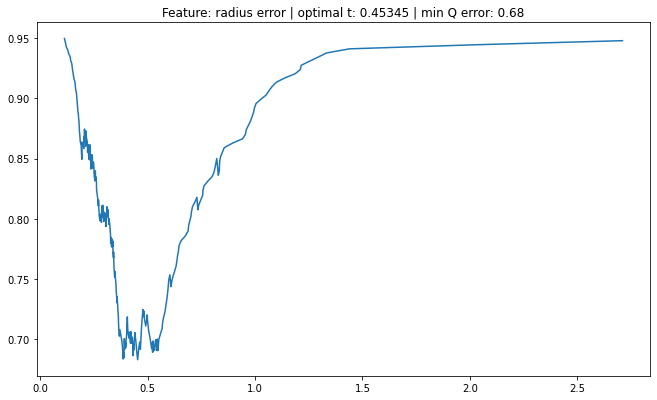

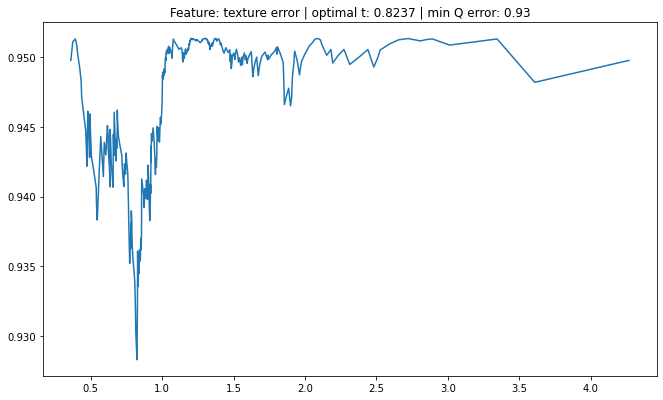

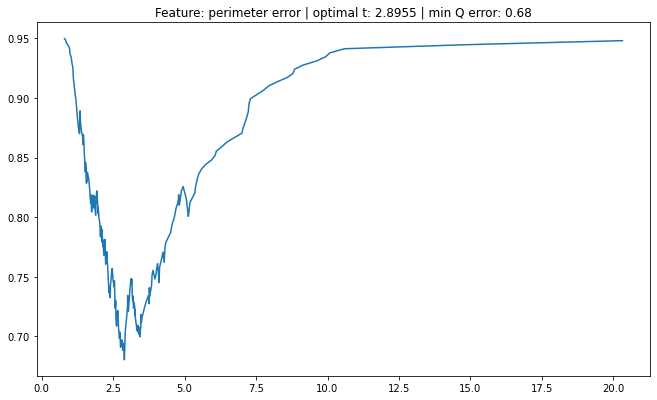

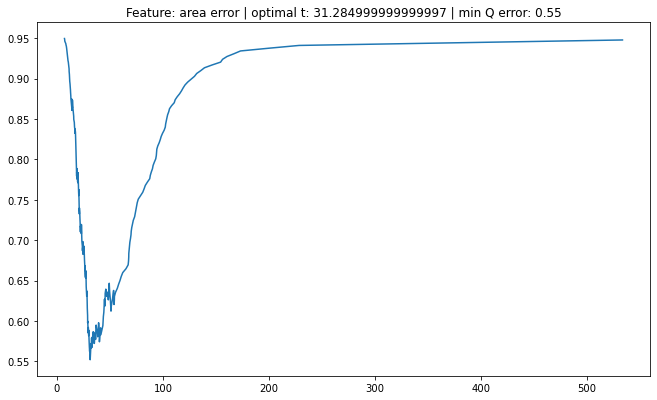

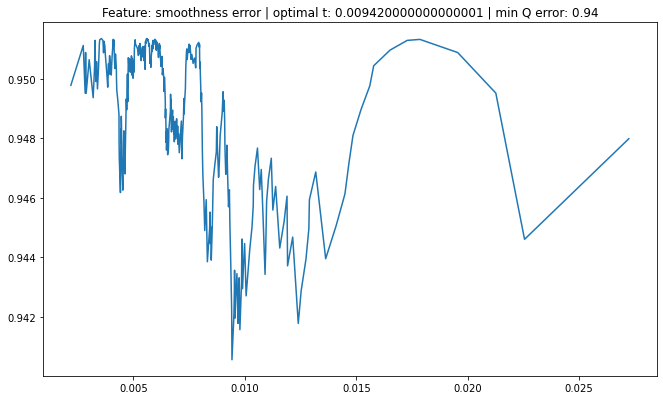

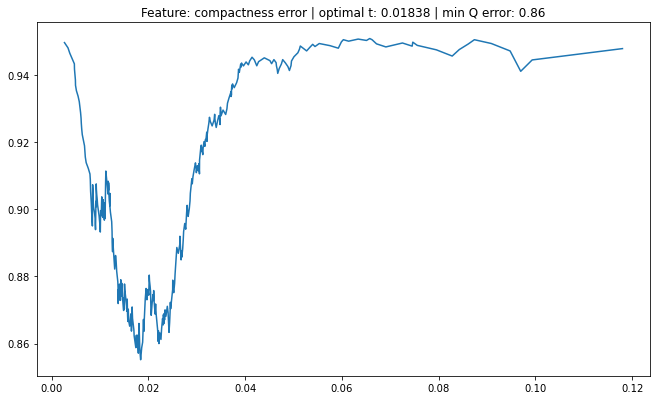

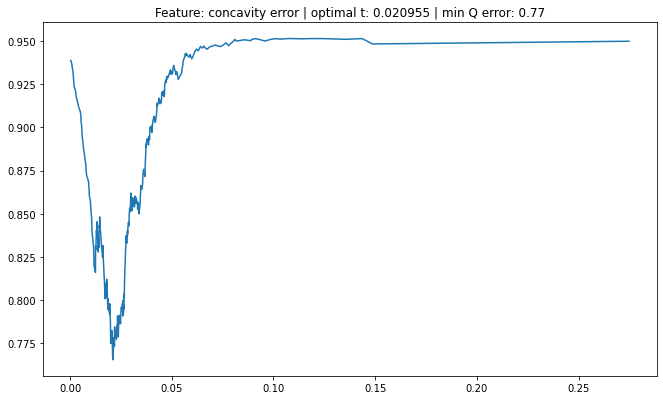

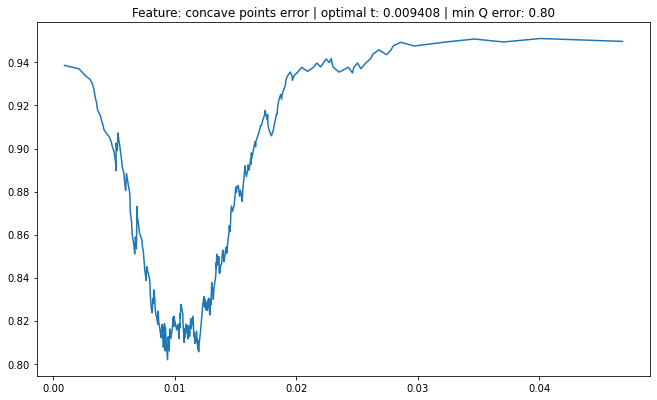

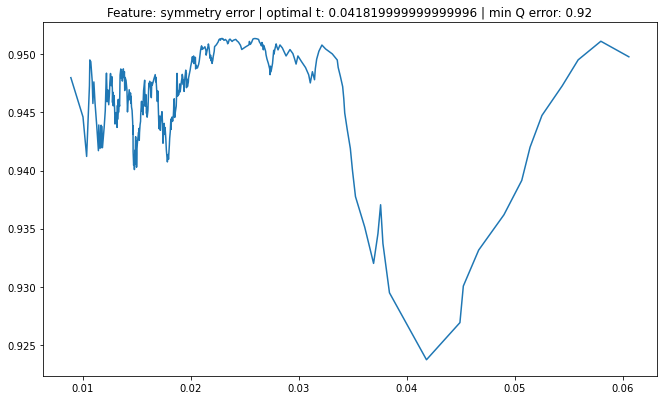

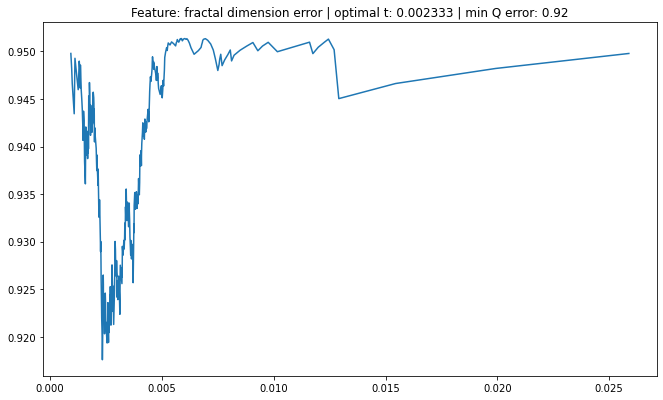

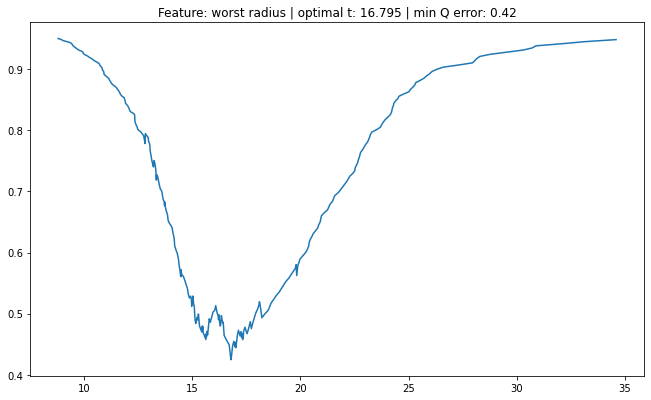

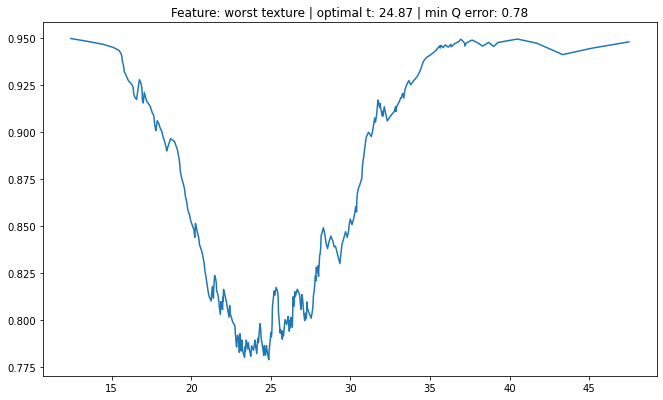

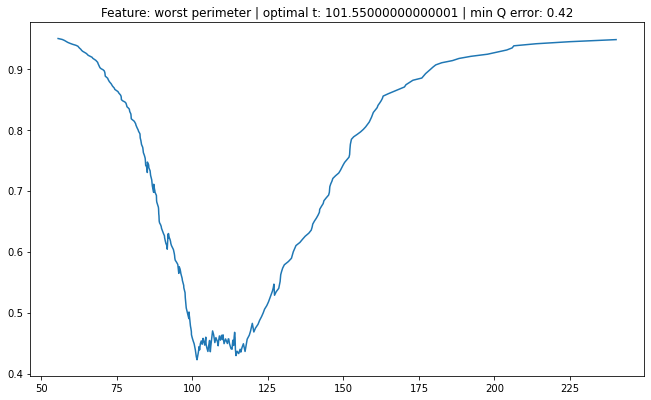

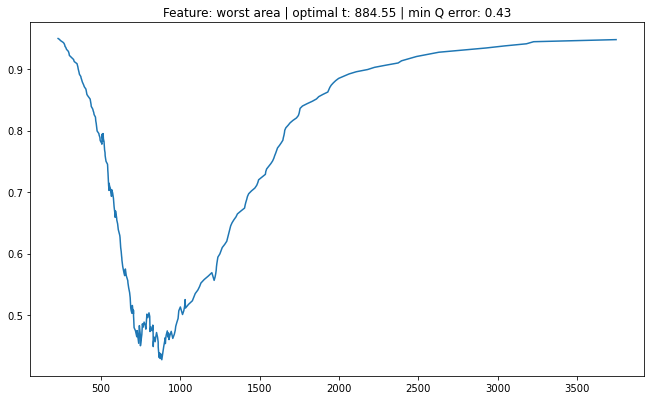

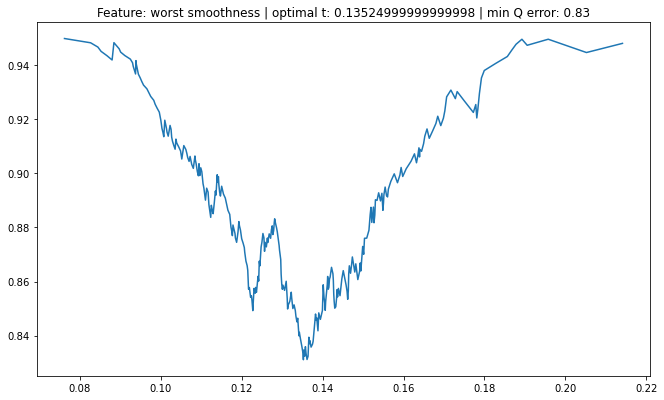

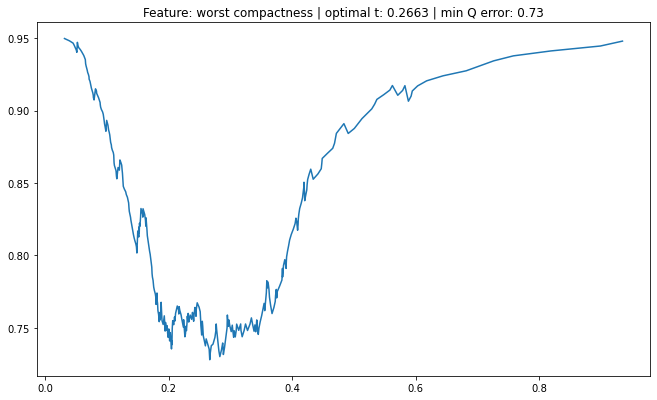

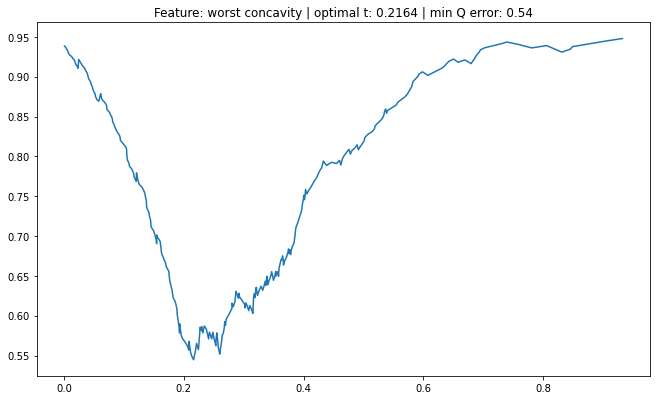

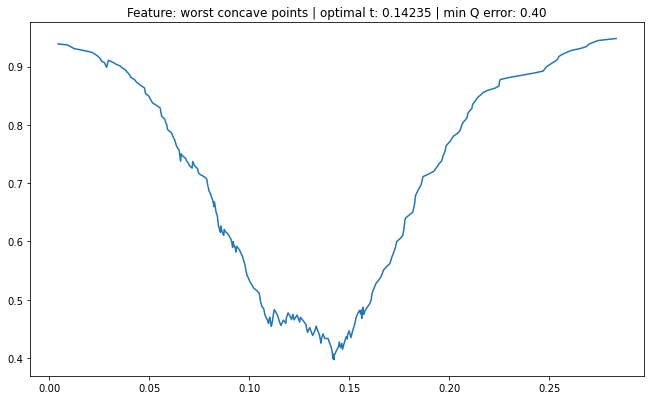

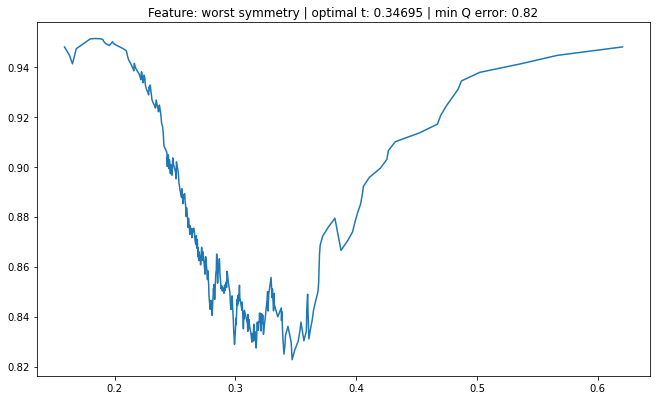

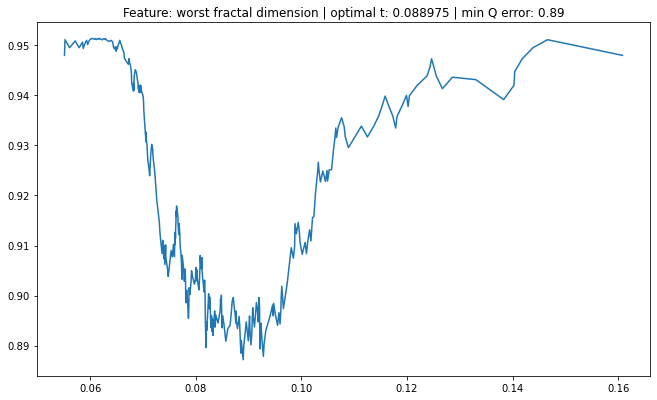

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [572]:
# ДОПОЛНИТЕЛЬНО ДЛЯ НАГЛЯДНОСТИ

# Графики для всех признаков:

results = []
for f in X_train.columns:
    t, q, Q_array = get_optimal_split(X_train, f)
    min_error = min(Q_array)
    results.append((f, t, min_error))
    feature_values = np.unique(X_train[f])
    feature_values_1 = (feature_values[:-1] + feature_values[1:]) / 2
    plt.figure()
    plt.title('Feature: {} | optimal t: {} | min Q error: {:.2f}'.format(f, t, min_error))
    plt.plot(feature_values_1, Q_array)
    plt.show()

In [573]:
results = sorted(results, key=lambda x: x[2])
print('Признак с минимальным значением критерия ошибки:', results[0][0])

Признак с минимальным значением критерия ошибки: mean concave points


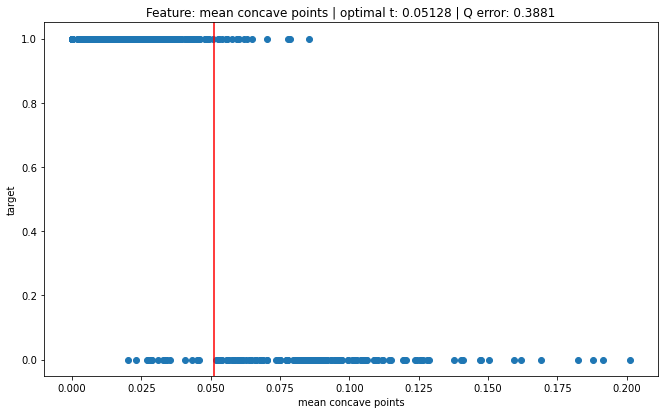

In [574]:
# График распределения значений признака "mean concave points" для нулевого и первого класса с прямой, указывающей местоположение порога:

optimal_feature, optimal_t, optimal_error = results[0]
plt.scatter(X_train[optimal_feature], X_train['target'])
plt.axvline(x=optimal_t, color="red")
plt.xlabel(optimal_feature)
plt.ylabel('target')
plt.title('Feature: {} | optimal t: {} | Q error: {:.4f}'.format(optimal_feature, optimal_t, optimal_error))
plt.show()

### 3. Строим дерево (5 баллов)

Теперь можно реализовать алгоритм целиком. Начинаем строить дерево с корня. В корне дерева находится вся обучающая выборка. Затем используем жадный алгоритм:

0. Проверяем критерий остановки - все элементы в вершине относятся к одному классу, ни по одному признаку нельзя разбить выборку, достигнута максимальная глубина дерева и пр.

1. Cреди всех признаков выбираем признак с минимальным значением критерия ошибки.

2. Разбиваем выборку на две подвыборки по наилучшему порогу для этого признака и из этих подвыборок получаем две новые дочерние вершины. 

3. Для каждой из них рекурсивно потворяем аналогичные действия.

__(3 балла)__ Заполните пропущенные строчки в функции __fit_node_ и реализуйте функцию __predict_node_.

In [575]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None
    ) -> None:
        
        if np.any(list(map(lambda x: x not in ('int64', 'float64', 'object'), feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой ("terminal" или "nonterminal"). Листовые вершины хранят значение класса для предсказания, 
        # нелистовые - правого и левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {"depth":0}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(
        self, 
        sub: pd.DataFrame, # подмножество объектов для данной вершины
        node: dict        # словарь для хранения информации о вершине
    ) -> None:
        
        # критерий остановки - проверяем что не все классы объектов в данной вершине одинаковы
        if np.all(sub['target'] == sub['target'].iloc[0]):
            node["type"] = "terminal"
            node["class"] = sub['target'].iloc[0]
            return
        
        
        # ищем лучший признак для разбиения
        feature_best, threshold_best, q_best = None, None, float("+inf")
        for feature in sub.columns[:-1]:
            feature_type = self._feature_types[feature]
              
            # ищем оптимальный порог для текущего признака
            threshold, q, q_array = get_optimal_split(sub, feature)
            
            
            # your code here
                        
            if q < q_best:
                threshold_best = threshold
                q_best = q
                feature_best = feature
                                                            

        # выбираем класс для листовой вершины
        if feature_best is None or node["depth"] == self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub['target']).most_common(1)[0][0]
            return
        
        # записываем полученное разбиение в атрибуты класса
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best
        sub_l, sub_r = split_node(sub, feature_best, threshold_best)
    
        # запускаем рекурсию
        node["left_child"], node["right_child"] = {"depth": node["depth"]+1}, {"depth": node["depth"]+1}
        self._fit_node(sub_l, node["left_child"])
        self._fit_node(sub_r, node["right_child"])

    def _predict_node(self, x: pd.Series, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: pd.Series, элемент выборки
        :param node: dict, вершина дерева
        """
        # your code here
        
        if node['type'] == 'terminal':
            return node['class']
        
        elif x[node['feature_split']] <= node['threshold']:
            return self._predict_node(x, node['left_child'])
        
        else:
            return self._predict_node(x, node['right_child'])
        
        
        
        # Альтернатива:
    
        # while node['type'] != 'terminal':
            
        #     if x[node['feature_split']] <= node['threshold']:
        #         node = node["left_child"]
                
        #     else:
        #         node = node["right_child"]
                    
        # return node['class']

        

    def fit(self, X: pd.DataFrame, y: np.ndarray) -> None:
        X['target'] = y
        self._fit_node(X, self._tree)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        predicted = []
        for ind, x in X.iterrows():
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)


__(1 балл)__ Обучите решающее дерево на обучающей части датасета (исключив колонку "mean area cat") и сравните accuracy полученную на обучающей и тестовой части. Совпадают ли топовые признаки с минимальным значением ошибки из предпредыдущего задания с признаками по которым произошли разбиения в дереве?

In [576]:
X_train_1 = X_train.drop(columns=['mean area cat', 'target'])
y_train_1 = X_train['target']
X_test_1 = X_test.drop(columns=['mean area cat', 'target'])
y_test_1 = X_test['target']

In [577]:
feature_types = X_train_1.dtypes

dt_1 = DecisionTree(feature_types=feature_types, max_depth=3, min_samples_split=15, min_samples_leaf=4)
dt_1.fit(X_train_1, y_train_1)
y_pred_1 = dt_1.predict(X_test_1)

In [578]:
# Accuracy, полученная на обучающей части:
y_true = y_train_1
accuracy_score(y_true, y_train_1)

1.0

In [579]:
# Однако лучше посчитать accuracy для предсказаний модели на обучающей выборке:
accuracy_score(dt_1.predict(X_train_1), y_train_1)

0.9812206572769953

In [580]:
# Accuracy, полученная на тестовой части:
accuracy_score(y_pred_1, y_test_1)

0.958041958041958

In [ ]:
# Accuracy, полученная на тестовой части, ниже, чем accuracy, полученная на обучающей части, однако обе достаточно высокие

In [581]:
dt_1._tree

# Первое разбиение происходит по признаку 'mean concave points', у которого минимальное значение ошибки, исходя из предыдущего задания
# Вывод: совпадают

{'depth': 0,
 'type': 'nonterminal',
 'feature_split': 'mean concave points',
 'threshold': 0.05128,
 'left_child': {'depth': 1,
  'type': 'nonterminal',
  'feature_split': 'worst radius',
  'threshold': 16.83,
  'left_child': {'depth': 2,
   'type': 'nonterminal',
   'feature_split': 'radius error',
   'threshold': 0.62555,
   'left_child': {'depth': 3, 'type': 'terminal', 'class': 1},
   'right_child': {'depth': 3, 'type': 'terminal', 'class': 0}},
  'right_child': {'depth': 2,
   'type': 'nonterminal',
   'feature_split': 'mean texture',
   'threshold': 16.189999999999998,
   'left_child': {'depth': 3, 'type': 'terminal', 'class': 1},
   'right_child': {'depth': 3, 'type': 'terminal', 'class': 0}}},
 'right_child': {'depth': 1,
  'type': 'nonterminal',
  'feature_split': 'worst perimeter',
  'threshold': 114.44999999999999,
  'left_child': {'depth': 2,
   'type': 'nonterminal',
   'feature_split': 'worst texture',
   'threshold': 25.655,
   'left_child': {'depth': 3, 'type': 'termin

__(1 балл)__ Как будет происходить разбиение в вершине дерева по категориальному признаку? Является ли оно эффективным? 

In [ ]:
# Разбиение в вершине дерева по категориальному признаку будет происходить в виде деления на число поддеревьев,
# равное количеству значений признака (классов). Из-за этого будет много листьев, что не является эффективным решением,
# однако в целом могут показываться высокие результаты.

# Также объекты могут отправляться в левую чать, если совпадают со значением признака, а в правую - если нет.

# Практическая часть (6 баллов)

__(2 балла)__ В этом задании нужно для того же датасета обучить несколько алгоритмов с помощью кросс-валидации и сравнить их качество по ROC AUC, accuracy и f1-score. Не забудьте удалить дополнительные колонки, которые были добавлены ранее.

1. Обучите и нарисуйте решающее дерево c глубиной 3. Настройте font_size или общий размер графика чтобы названия признаков были читабельны. Сравните его с деревом, которое вы написали самостоятельно. Для решающего дерева подберите оптимальный max_depth и min_samples_split по выбранной метрике.

2. Обучите логистическую регрессию c L2 регуляризацией и подберите для нее наилучший параметр.

3. Обучите SVM и выберите наиболее подходящее ядро и параметр регуляриации.


Выберите метрику, по которой вы будете выбирать наилучшие параметры. Почему для этого датасета стоит сравнивать предсказания не только по значению accuracy? Что важнее для этой задачи - оптимизировать precision или recall? 

In [455]:
X_train_3 = X_train.drop(columns=['mean area cat', 'target'])
y_train_3 = X_train['target']
X_test_3 = X_test.drop(columns=['mean area cat', 'target'])
y_test_3 = X_test['target']

dt = DecisionTreeClassifier(max_depth=3, random_state=13)
dt.fit(X_train_3, y_train_3)
y_pred = dt.predict(X_test_3)

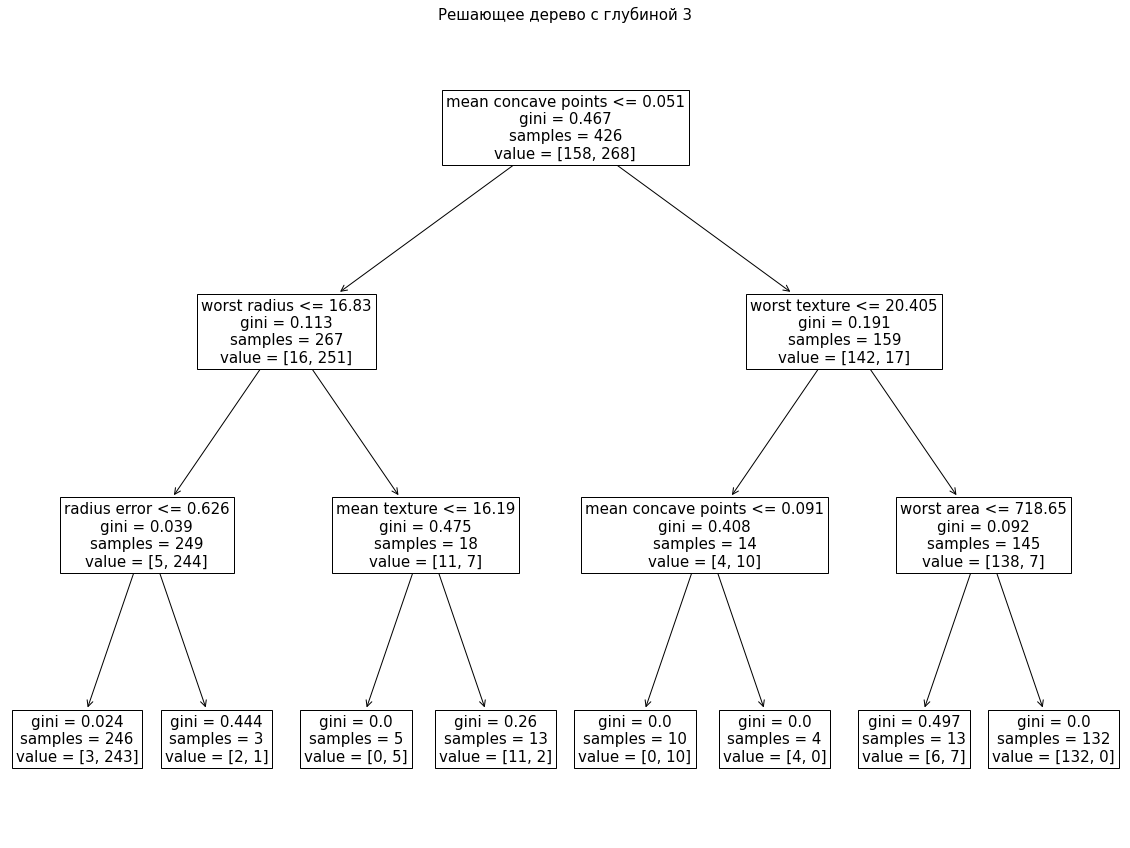

In [456]:
feature_names = X.columns
plt.figure(figsize=(20,15))
plot_tree(dt, feature_names=feature_names, fontsize = 15)
plt.title('Решающее дерево c глубиной 3', fontsize = 15);

# Дерево похоже на написанное самостоятельно: врначале идут такие же разбиения (одинаковые признаки и пороги), но небольшие различия есть, что видно из рисунка

In [490]:
tree_parameters = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid={'max_depth': range(1, 7),'min_samples_split': range(1, 20, 2)})
tree_parameters.fit(X_train_3, y_train_3)
tree_parameters.predict(X_test_3)
tree_parameters_best = tree_parameters.best_params_

decision_tree = DecisionTreeClassifier(max_depth=tree_parameters_best['max_depth'], min_samples_split=tree_parameters_best['min_samples_split'])
decision_tree.fit(X_train_3, y_train_3)
pred_tree = decision_tree.predict(X_test_3)
print('ROC AUC для обучающего дерева: ', roc_auc_score(pred_tree, y_test_3))
print('Accuracy для обучающего дерева: ', accuracy_score(pred_tree, y_test_3))
print('f1-score для обучающего дерева: ', f1_score(pred_tree, y_test_3))
print('Лучшие гиперпараметры:', tree_parameters_best)

ROC AUC для обучающего дерева:  0.9381157635467982
Accuracy для обучающего дерева:  0.9440559440559441
f1-score для обучающего дерева:  0.9545454545454545
Лучшие гиперпараметры: {'max_depth': 6, 'min_samples_split': 9}


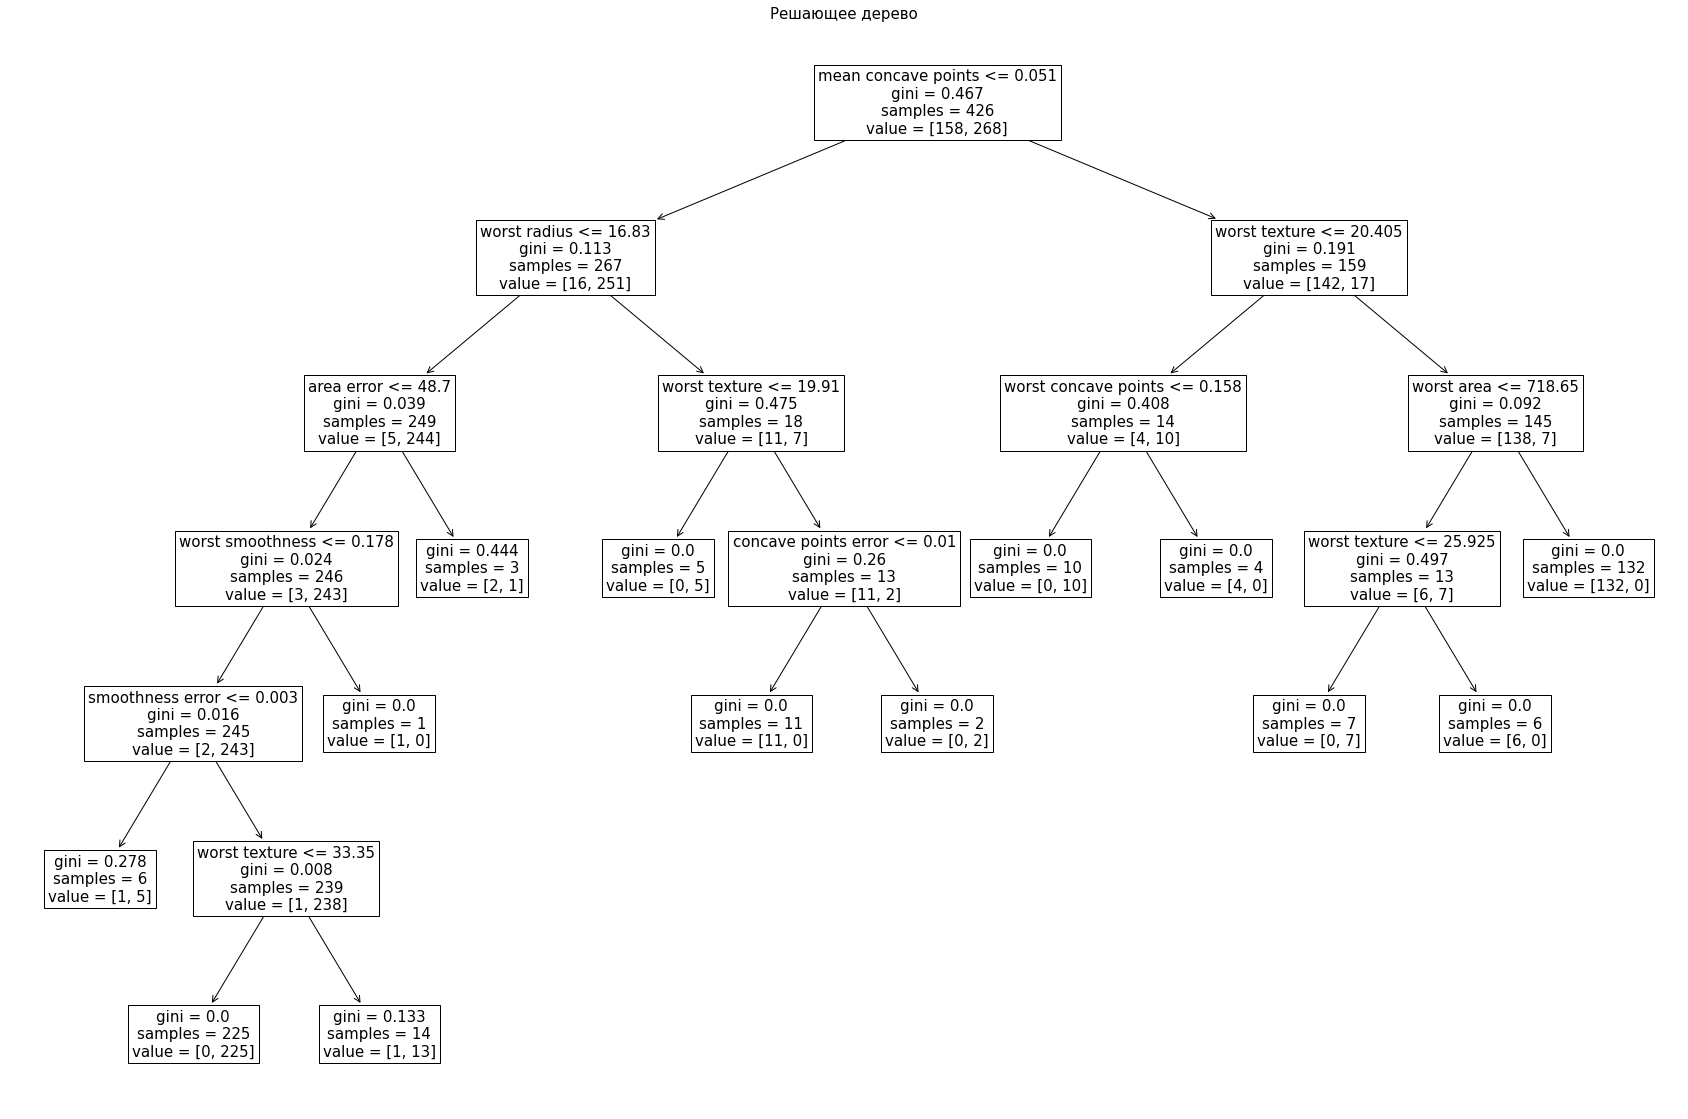

In [496]:
feature_names = X.columns
plt.figure(figsize=(30,20))
plot_tree(decision_tree, feature_names=feature_names, fontsize = 15)
plt.title('Решающее дерево', fontsize = 15);

In [498]:
# Более компактный код:

tree = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid={'max_depth': range(1, 7),'min_samples_split': range(1, 20, 2)})
tree.fit(X_train_3, y_train_3)
tree_pred = tree.predict(X_test_3)

print('ROC AUC для обучающего дерева: ', roc_auc_score(tree_pred, y_test_3))
print('Accuracy для обучающего дерева: ', accuracy_score(tree_pred, y_test_3))
print('f1-score для обучающего дерева: ', f1_score(tree_pred, y_test_3))
print('Лучшие гиперпараметры:', tree.best_params_)

ROC AUC для обучающего дерева:  0.9381157635467982
Accuracy для обучающего дерева:  0.9440559440559441
f1-score для обучающего дерева:  0.9545454545454545
Лучшие гиперпараметры: {'max_depth': 6, 'min_samples_split': 9}


In [507]:
logreg = GridSearchCV(LogisticRegression(penalty='l2'), param_grid={'C':  np.logspace(-2, 2, 20)})
logreg.fit(X_train_3, y_train_3)
logreg_pred = logreg.predict(X_test_3)

print('ROC AUC для логистической регрессии с L2 регуляризацией: ', roc_auc_score(logreg_pred, y_test_3))
print('Accuracy для логистической регрессии с L2 регуляризацией: ', accuracy_score(logreg_pred, y_test_3))
print('f1-score для логистической регрессии с L2 регуляризацией: ', f1_score(logreg_pred, y_test_3))
print('Лучшие гиперпараметры:', logreg.best_params_)

ROC AUC для логистической регрессии с L2 регуляризацией:  0.9644654088050315
Accuracy для логистической регрессии с L2 регуляризацией:  0.965034965034965
f1-score для логистической регрессии с L2 регуляризацией:  0.9720670391061451
Лучшие гиперпараметры: {'C': 37.92690190732246}


In [511]:
svm = GridSearchCV(SVC(), param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': range(0, 30, 2)})
svm.fit(X_train_3, y_train_3)
svm_pred = svm.predict(X_test_3)

print('ROC AUC для SVM: ', roc_auc_score(svm_pred, y_test_3))
print('Accuracy для SVM: ', accuracy_score(svm_pred, y_test_3))
print('f1-score для SVM: ', f1_score(svm_pred, y_test_3))
print('Лучшие гиперпараметры:', svm.best_params_)

ROC AUC для SVM:  0.9613636363636363
Accuracy для SVM:  0.965034965034965
f1-score для SVM:  0.9717514124293786
Лучшие гиперпараметры: {'C': 10, 'kernel': 'linear'}


In [ ]:
# Поскольку в данном случае пример с серьезным заболеванием, то важно найти как можно больше больных,
# то есть лучше здорового посчитать за больного, чем больного за здорового, поэтому важнее оптимизировать recall.

# В данной задаче неравномерное распределение классов, поэтому нужно использовать метрику, менее чувствительную к этому.
# Метрика ROC-AUC не чувствительна к смещению, поэтому нет необходимости выравнивать дисбаланс классов.

# Для этого датасета стоит сравнивать предсказания не только по значению accuracy, 
# потому что accuracy как раз чувствительна к несбалансированности классов, что может исказить результаты.

Теперь загрузим еще один [датасет](https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification). По данным о клиентам банка нужно предсказать будет ли клиент брать кредит на длительный срок или нет. И если да, то сотрудники банка позвонят и предложат ему кредит. 

In [91]:
df = pd.read_csv('new_train.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [583]:
X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.25, random_state=42)
X_train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
29882,37,services,married,high.school,no,no,telephone,may,wed,110,8,0,nonexistent,no
8191,45,technician,single,university.degree,no,no,cellular,aug,tue,117,4,0,nonexistent,no
25120,31,student,single,unknown,no,yes,cellular,apr,thu,246,1,1,failure,no
10981,37,technician,married,professional.course,no,no,cellular,nov,fri,210,3,0,nonexistent,no
970,41,blue-collar,married,basic.9y,no,no,telephone,may,mon,198,1,0,nonexistent,no


__(0.5 балла)__ Изучите и подготовьте данные - проверьте типы колонок, соотношение классов, наличие пропусков (пропуски для категориальных переменных указаны как 'unknown'), повторяющихся объектов, проверьте частоты значений признаков и их смысл - возможно какие-то признаки можно удалить. 

In [87]:
# Типы колонок:
df.dtypes

# 5 целочисленных типов даных и 11 категориальных типов данных

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [181]:
# Соотношение классов:
df['y'].value_counts(normalize=True)

no     0.887344
yes    0.112656
Name: y, dtype: float64

In [92]:
# Наличие пропусков (пустых значений):
pd.isnull(df).any().any()

# Null-значений в данных нет

False

In [149]:
# Наличие пропусков ('unknown'):
for column in df.columns:
    if df[column].values.__contains__('unknown') == True:
        amount = df[column][df[column] == 'unknown'].value_counts()[0]
        print (f'Столбец "{column}" содержит {amount} значений "unknown"','',sep='\n')

Столбец "job" содержит 265 значений "unknown"

Столбец "marital" содержит 65 значений "unknown"

Столбец "education" содержит 1397 значений "unknown"

Столбец "default" содержит 6940 значений "unknown"

Столбец "housing" содержит 796 значений "unknown"

Столбец "loan" содержит 796 значений "unknown"



In [152]:
for column in df.columns:
    print(f'Частоты значений признака {column}:', df[column].value_counts(),'',sep='\n')

Частоты значений признака age:
31    1551
32    1474
33    1443
35    1417
34    1404
      ... 
17       3
89       2
87       1
91       1
98       1
Name: age, Length: 75, dtype: int64

Частоты значений признака job:
admin.           8314
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
unknown           265
Name: job, dtype: int64

Частоты значений признака marital:
married     19953
single       9257
divorced     3675
unknown        65
Name: marital, dtype: int64

Частоты значений признака education:
university.degree      9736
high.school            7596
basic.9y               4826
professional.course    4192
basic.4y               3322
basic.6y               1865
unknown                1397
illiterate               16
Name: education, dtype: int64

Частоты значений признака default:
no         26007
unknown    

In [547]:
# Данные признаки имеют много одинаковых значений:
for column in ['default', 'pdays', 'previous', 'poutcome']:
    print(f'Доли значений признака {column}:', df[column].value_counts(normalize=True),'',sep='\n')

# Можно удалить столбец "default", так как там 78,9% значений "no" и при этом много (21%) значений "unknown", 
# то есть если заменять на один из двух признаков, то логичнее выбрать "no" (а также если неизвестно, есть ли кредит в дефолте,
# то не стоит предполагать, что он есть, даже если распределение значений "yes" и "no" равномерное), 
# и тогда остается меньше 0.01% значений "yes".

# Также можно удалить столбец "pdays", так как в нем больше 95% повторяющихся значений, а остальных не больше 1%.

# Столбцы 'previous' и 'poutcome' удалять не следует, так как там меньше 90% повторяющихся значений, 
# а значит, они все-таки могут быть полезны для анализа.

Доли значений признака default:
no         0.789287
unknown    0.210622
yes        0.000091
Name: default, dtype: float64

Доли значений признака pdays:
999    0.962792
3      0.010774
6      0.010228
4      0.002944
2      0.001578
7      0.001426
9      0.001366
10     0.001305
12     0.001214
5      0.001214
13     0.000850
1      0.000668
11     0.000637
15     0.000637
14     0.000546
8      0.000425
0      0.000364
16     0.000273
17     0.000243
18     0.000182
22     0.000091
19     0.000061
21     0.000061
27     0.000030
25     0.000030
20     0.000030
26     0.000030
Name: pdays, dtype: float64

Доли значений признака previous:
0    0.862398
1    0.111472
2    0.018392
3    0.005311
4    0.001821
5    0.000425
6    0.000152
7    0.000030
Name: previous, dtype: float64

Доли значений признака poutcome:
nonexistent    0.862398
failure        0.104067
success        0.033536
Name: poutcome, dtype: float64



In [515]:
# Корреляция между признаками по убыванию:
df.corr().unstack().sort_values(ascending=False).head(50)[df.corr().unstack() < 1]

# Нет признаков, которые сильно коррелируют, поэтому удалять их из этих соображений не стоит.

campaign  pdays       0.053795
pdays     campaign    0.053795
previous  duration    0.022538
duration  previous    0.022538
previous  age         0.020670
age       previous    0.020670
campaign  age         0.003302
age       campaign    0.003302
          duration   -0.001841
duration  age        -0.001841
pdays     age        -0.032011
age       pdays      -0.032011
pdays     duration   -0.047127
duration  pdays      -0.047127
campaign  duration   -0.075663
duration  campaign   -0.075663
previous  campaign   -0.079051
campaign  previous   -0.079051
pdays     previous   -0.589601
previous  pdays      -0.589601
dtype: float64

In [548]:
df = df.drop(columns=['default', 'pdays'])
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,cellular,jun,tue,368,2,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28,services,single,high.school,yes,no,cellular,jul,tue,192,1,0,nonexistent,no
32946,52,technician,married,professional.course,yes,no,cellular,nov,fri,64,1,1,failure,no
32947,54,admin.,married,basic.9y,no,yes,cellular,jul,mon,131,4,0,nonexistent,no
32948,29,admin.,married,university.degree,no,no,telephone,may,fri,165,1,0,nonexistent,no


__(0.5 балла)__ Постройте графики с распределениями по каждому из категориальных признаков. Статистики должны быть выведены для обоих классов и либо расположены на одном графике, либо находиться на соседних графиках, чтобы можно было сравнить их между собой. Вам поможет plt.subplot(s) если вы используете matplotlib или продвинутые функции из seaborn, позволяющие автоматически строить сразу несколько графиков. Убедитесь что на графиках подписаны оси, все надписи читабельны и пр. Проанализируйте полученные результаты.

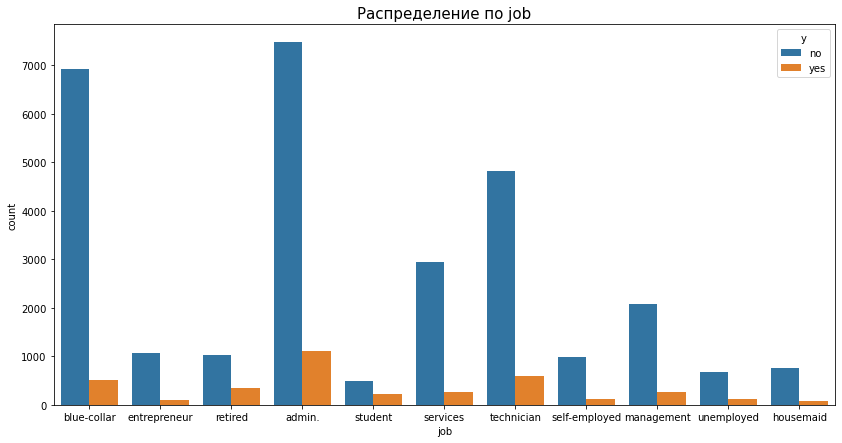

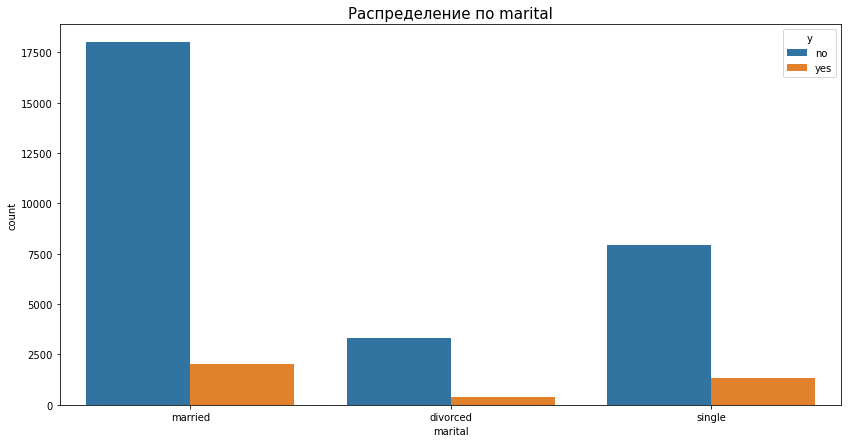

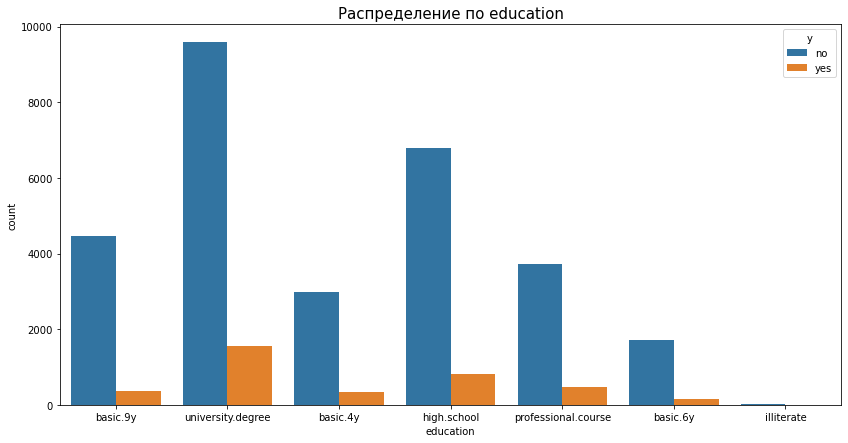

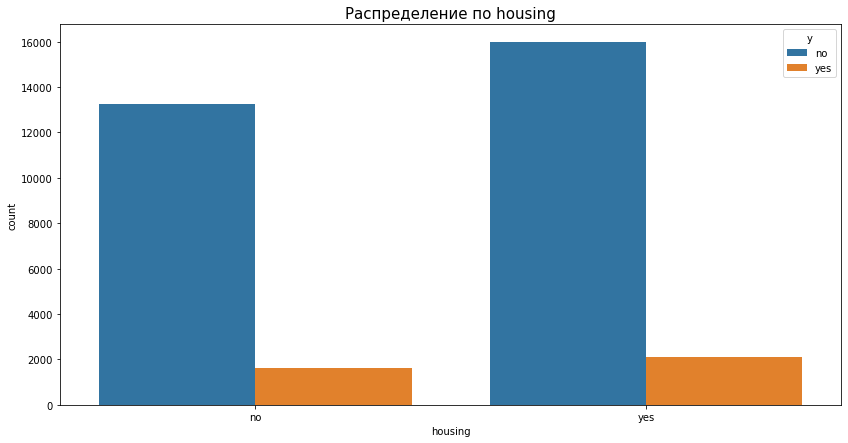

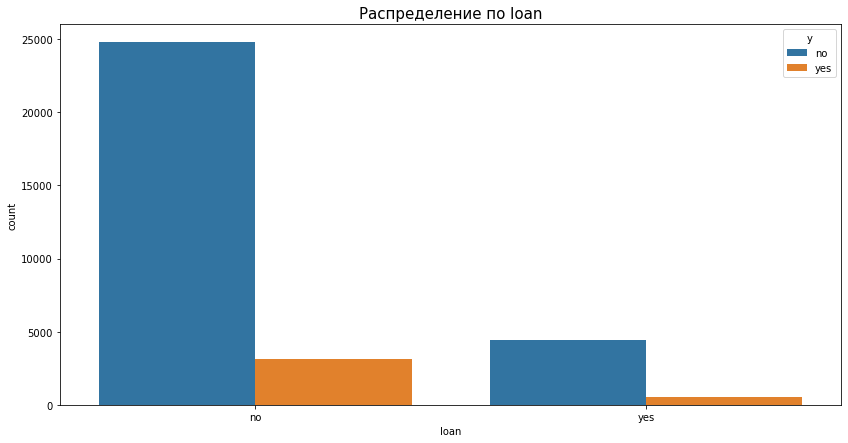

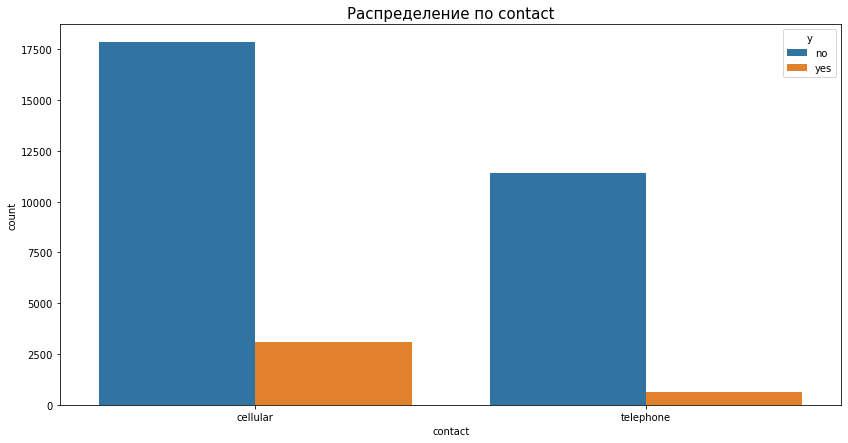

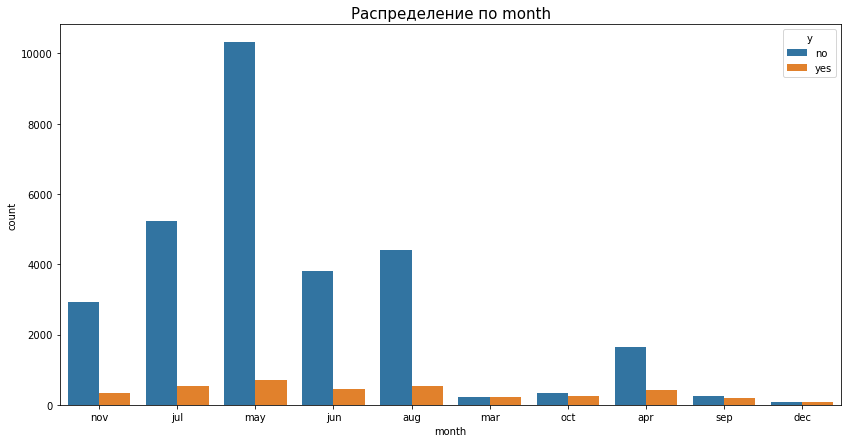

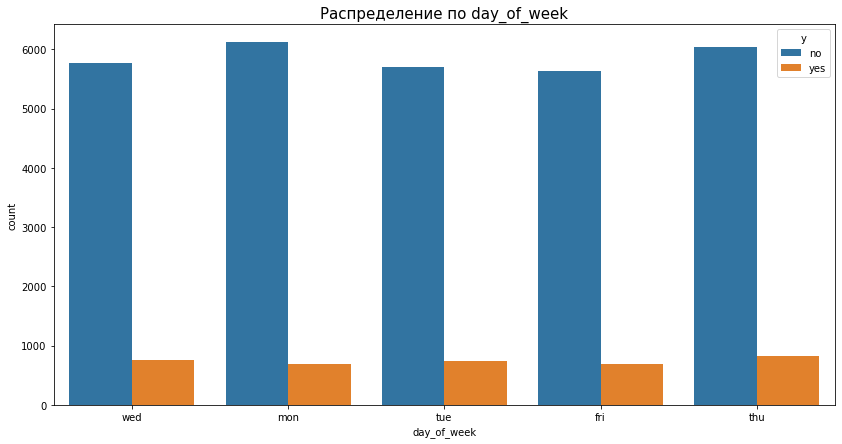

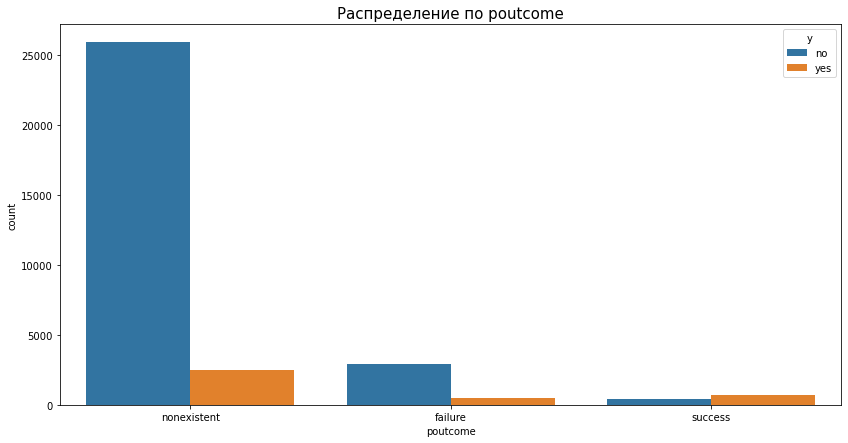

In [681]:
columns = df.columns[df.dtypes == 'object']
df_new = df[columns]

for column in columns.drop('y'):
    plt.figure(figsize=(14, 7))
    sns.countplot(x=column, data=df_new, hue='y')
    plt.title(label=f'Распределение по {column}', fontsize=15)
    
# Как видно из графиков, везде преобладает класс "no", то есть клиенты с любыми признаками, в основном, не офоромили депозит.
# Также если какие-то категории (как "nonexistent" в признаке "poutcome") значительно больше других,
# это может говорить о том, что данные распределены неравномерно по данному признаку

__(0.5 балла)__ Проведите анализ числовых признаков - постройте попарные графики для признаков и график с корреляцией Пирсона.

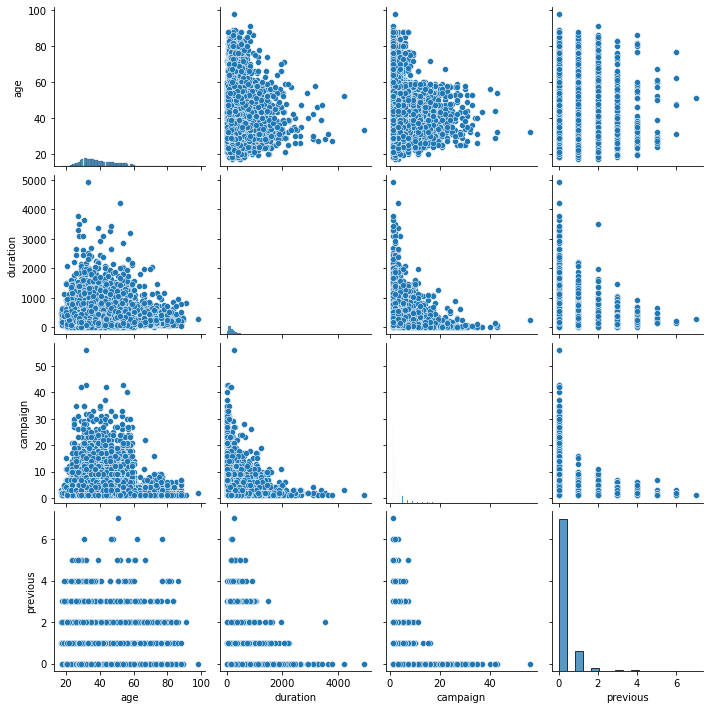

In [585]:
# Попарные графики для признаков:
sns.pairplot(df);

In [586]:
# Корреляция Пирсона между числовыми признаками:
df.corr()

,age,duration,campaign,previous
age,1.000000,-0.001841,0.003302,0.020670
duration,-0.001841,1.000000,-0.075663,0.022538
campaign,0.003302,-0.075663,1.000000,-0.079051
previous,0.020670,0.022538,-0.079051,1.000000


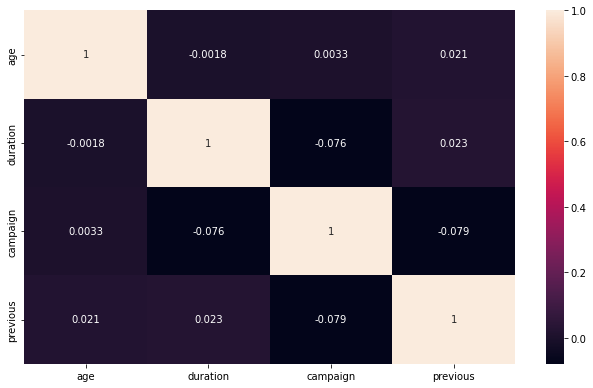

In [588]:
# Корреляция Пирсона между числовыми признаками изображена в виде тепловой карты:
sns.heatmap(df.corr(), annot=True);

In [ ]:
# Выборка несбалансированная.
# Столбцы "pdays" и "previous" имеют самую большую корреляцию, причем отрицательную.
# Значения распределены неравномерно, некоторые дискретны.

__(0.5 балл)__ Преобразуйте категориальные признаки. Подумайте какие признаки лучше закодировать с помощью one-hot encoding, а какие с помощью label-encoding.

In [651]:
# Так как в задании не было сказано, что нужно заполнить неявные пропуски ("unknown"), то я это сделаю для копии данных.
# Замена неявных пропусков на наиболее распространенное значение:
import statistics

df_without_unknown = df
columns = df_without_unknown.columns[df_without_unknown.dtypes == 'object'].drop('y')

for column in columns:
    df_without_unknown[column][df_without_unknown[column] == 'unknown'] = statistics.mode(df_without_unknown[column])

In [654]:
df_without_unknown = pd.get_dummies(df_without_unknown, columns=['marital', 'contact', 'poutcome'])

# Также значения столбца "poutcome" можно было бы обработать так: неуспешный - (-1), успешный - 1, несуществующий - 0.
# В таком случае неудача будет учитываться с минусом, успех с плюсом, а отсутствие результата - никак.
# df_without_unknown['poutcome'] = df_without_unknown['poutcome'].replace(['nonexistent', 'failure', 'success'], [0, -1, 1])

In [655]:
# Данные признаки являются бинарными, поэтому можно просто заменить да на 1, а нет - на 0:
df_without_unknown['housing'] = df_without_unknown['housing'].replace(['yes', 'no'], [1, 0])
df_without_unknown['loan'] = df_without_unknown['loan'].replace(['yes', 'no'], [1, 0])
df_without_unknown['y'] = df_without_unknown['y'].replace(['yes', 'no'], [1, 0])

In [656]:
# Если значений у категориального признака много и нельзя сказать, какое важнее, то можно использовать mean target encoding.
# (Я читала, что от этого модель может переобучиться, но ассистент посоветовал такую функцию, 
# тем более не так много значений будет закодировано таким способом, а также эту проблему может решить регуляризация).
def mean_target_encoding(df, target, column):
    mean_encoding = df.groupby(column)[target].mean()
    df[column] = df[column].map(mean_encoding)
    return (df)

In [657]:
mean_target_encoding(df_without_unknown, 'y', 'month')
mean_target_encoding(df_without_unknown, 'y', 'day_of_week')

,age,job,education,housing,loan,month,day_of_week,duration,campaign,previous,y,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,49,blue-collar,basic.9y,0,0,0.101653,0.115579,227,4,0,0,0,1,0,1,0,0,1,0
1,37,entrepreneur,university.degree,0,0,0.101653,0.115579,202,2,1,0,0,1,0,0,1,1,0,0
2,78,retired,basic.4y,0,0,0.092313,0.102466,1148,1,0,1,0,1,0,1,0,0,1,0
3,36,admin.,university.degree,1,0,0.063482,0.102466,120,2,0,0,0,1,0,0,1,0,1,0
4,59,retired,university.degree,0,0,0.103838,0.116077,368,2,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28,services,high.school,1,0,0.092313,0.116077,192,1,0,0,0,0,1,1,0,0,1,0
32946,52,technician,professional.course,1,0,0.101653,0.109143,64,1,1,0,0,1,0,1,0,1,0,0
32947,54,admin.,basic.9y,0,1,0.092313,0.102466,131,4,0,0,0,1,0,1,0,0,1,0
32948,29,admin.,university.degree,0,0,0.063482,0.109143,165,1,0,0,0,1,0,0,1,0,1,0


In [658]:
# Еще один способ кодирования - замена каждой категории числом входящих в неё объектов:
df_without_unknown['job'] = df_without_unknown['job'].map(df_without_unknown.groupby('job').size())
df_without_unknown['education'] = df_without_unknown['education'].map(df_without_unknown.groupby('education').size())

# Возможно, разный уровень образования должен иметь разный вес, но я не знаю, в каком порядке правильно расставить данные категории

In [663]:
# Проверка:
df_without_unknown.dtypes

age                       int64
job                       int64
education                 int64
housing                   int64
loan                      int64
month                   float64
day_of_week             float64
duration                  int64
campaign                  int64
previous                  int64
y                         int64
marital_divorced          uint8
marital_married           uint8
marital_single            uint8
contact_cellular          uint8
contact_telephone         uint8
poutcome_failure          uint8
poutcome_nonexistent      uint8
poutcome_success          uint8
dtype: object

__(1 балл)__ В этом датасете отношение между положительными примерами и отрицательными практически 1:8. Поэтому хорошей идеей будет сбалансировать датасет (oversampling - добавить элементы менее популярного класса на основе имеющихся или undersampling - наоборот убрать элементы более популярного класса. см. [imblearn](https://imbalanced-learn.org/stable/over_sampling.html#a-practical-guide)) или пропорционально изменить веса классов в самих моделях (параметр class_weight), а также использовать чувствительные к таким случаям метрики. 

Разбейте датасет на train и test, используйте параметр stratify, чтобы соотношение классов не изменилось после разбиения датасета на две части. Аналогично в дальнейшем при использовании кросс-валидации используйте версию функции сохраняющую соотношение классов (StratifiedKFold). 

Подберите параметры логистической регрессии и решающего дерева с помощью кросс-валидации по AUC PR (площадь под Precision-Recall кривой). Для тестовой части датасета выведите получившиеся значения AUC PR, f1-score, PR-кривую и выведите матрицы для истинных значений и предсказаний (confusion matrix). Их можно красиво вывести с помощью seaborn.heatmap(). На что стоит больше обращать внимание - на ошибку первого или второго рода?

In [696]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score

X = df_without_unknown.drop(columns='y')
y = df_without_unknown['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [688]:
sf = StratifiedKFold(5, random_state=42, shuffle=True)

logreg = GridSearchCV(LogisticRegression(penalty='l2'), param_grid={'C': np.logspace(-2, 2, 20)}, cv=sf.split(X_train, y_train), scoring= 'average_precision')
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)


In [704]:
# НЕ ДОДЕЛАНО

sf_1 = StratifiedKFold(5, random_state=42, shuffle=True)

dt = DecisionTreeClassifier(max_depth=4)
logreg = LogisticRegression(penalty='l2')
models = []
models.append(dt)
models.append(logreg)

for i in range(len(models)):
    auc = np.mean(cross_val_score(models[i], X_train, y_train, scoring='average_precision', cv = sf_1))
    
    if i == 0:
        print('Для решающего дерева:')
        
    elif i == 1:
        print('Для логистической регрессия с c L2 регуляризацией:')
    
    print('PR AUC:', auc, '\n')

Для решающего дерева:
PR AUC: 0.49471665135346105 

Для логистической регрессия с c L2 регуляризацией:
PR AUC: 0.4515510565089043 



In [ ]:
# Cтоит обращать больше внимания на ошибку первого рода, так как они показывают случаи, когда предсказывали true, 
# а на самом деле оказалось false (false positive), и получается, что банк потратил деньги на привлечение клиентов зря.
# Ошибки второго рода показывают случаи, когда банк не привлек клиентов, которые готовы были открыть депозит или взять кредит,
# но не сделал этого, тем самым не получив дополнительный доход (предсказывали false, а на самом деле оказалось true (false negative)).
# В случае с банком потеря возможности получения дополнительного дохода лучше, чем убытки из-за ошибок модели.

__(0.5 балла)__ Рассмотрим задачу с точки зрения прибыли для банка. Маркетинговая компания требует значительных финансовых затрат, и ее эффективность напрямую зависит от качества нашей модели. Поэтому в качестве дополнительной метрики качества разумно использовать общую прибыль банка в той или иной форме. Мы будем рассматривать очень простую модель. Пусть каждый клиент после возврата всех процентов по кредиту (и с учетом всех расходов на обслуживание) приносит банку в среднем 10000 у.е., затраты на привлечение одного клиента составляют 100 у.е. Тогда сколько составит прибыль банка (доходы - расходы) если работники банка свяжутся со всеми клиентами, которых предсказала наша лучшая модель как подходящих на тестовой части и они все согласятся открыть кредит? Сколько составят расходы на маркетинг? В данной модели мы не учитываем что кредит может быть не возвращен в срок.

In [558]:
def revenue(y_true, y_pred):
    
    income = sum(y_pred) * 1000
    loss = sum(y_true[y_pred==1]) * 100
    revenue = income - loss
    
    return revenue, loss

# y_test = 
# y_pred = 

# print(f'Прибыль составит: {revenue(y_test, y_pred)[0]}', 
#      f'расходы на маркетинг составят: {revenue(y_test, y_pred)[1]}', sep='\n')

# Я не напечатала, что выводит функция, из-за нехватки времени, но проверяла в начале на других данных, она работает

Прибыль составит: 78600
расходы на маркетинг составят: 8400


__(0.5 балла)__ Снова используйте кросс-валидацию с пятью подвыборками. Обучите логистическую регрессию и выведите пять значений прибыли, а также подсчитайте среднее значение. Постройте графики зависимости среднего значения прибыли и AUC PR от параметра регуляризации.

In [ ]:
# НЕ ДОДЕЛАНО

plt.plot(параметр регуляризации, среднее значение прибыли)
plt.title(f'График зависимости cреднего значения прибыли от параметра регуляризации')
plt.xlabel(f'Параметр регуляризации')
plt.ylabel('Среднее значение прибыли');

plt.plot(параметр регуляризации, среднее значение AUC PR )
plt.title(f'График зависимости cреднего значения AUC PR от параметра регуляризации')
plt.xlabel(f'Параметр регуляризации')
plt.ylabel('Среднее значение AUC PR');